In [19]:
import uproot
import numpy as np
from reco.plotting import plot_event, plot_tracksters
from reco.evaluation import evaluate
from reco.event import remap_array_by_label
from reco.energy import get_total_energy
import matplotlib.pyplot as plt
%matplotlib inline

file_name = "~/Data/pions/new_ntuples_14955802_7.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 38, tracksters sim: 2
Simulated energy: 574.03, reconstructed energy: 447.56 (77.97%)


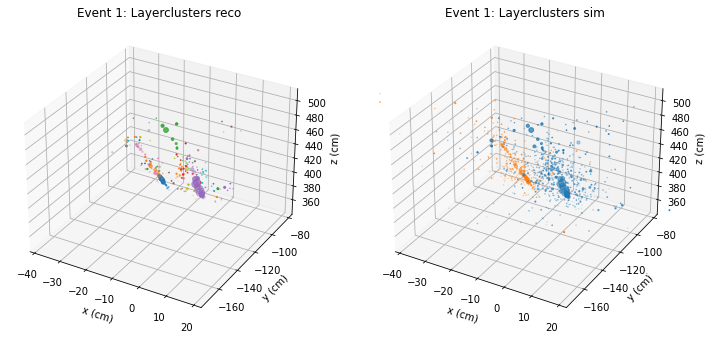

In [20]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

In [21]:
precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.98, Recall: 0.15, F-score: 0.25


## k-means

In [22]:
from sklearn.cluster import KMeans

x_bary = tracksters["barycenter_x"].array()[eid]
y_bary = tracksters["barycenter_y"].array()[eid]
z_bary = tracksters["barycenter_z"].array()[eid]

In [23]:
X = np.array([x_bary, y_bary, z_bary]).T

In [24]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [25]:
ri = remap_array_by_label(t_indexes, kmeans.labels_)
re = remap_array_by_label(t_energy, kmeans.labels_)
rm = remap_array_by_label(v_multi, kmeans.labels_)

In [26]:
precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.67, Recall: 0.84, F-score: 0.75


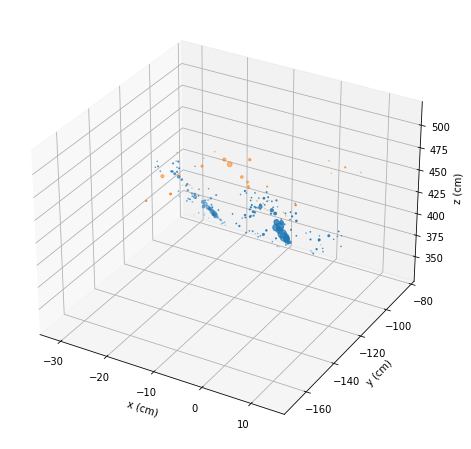

In [27]:
rx = remap_array_by_label(tracksters["vertices_x"].array()[eid], kmeans.labels_)
ry = remap_array_by_label(tracksters["vertices_y"].array()[eid], kmeans.labels_)
rz = remap_array_by_label(tracksters["vertices_z"].array()[eid], kmeans.labels_)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)

plt.show()